In [1]:
from music21 import *
from IPython.display import Image

us = environment.UserSettings()
# work computers location
us["musicxmlPath"] = (
    "C:/Users/circ8/Documents/Chris/MuseScorePortableLegacy3/MuseScorePortable.exe"
)
# macOS location
# us['musicxmlPath'] = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'


def music(notes: str, midi: bool = False):
    s = stream.Score()
    part = stream.Part()

    # get info
    info_start = 5

    for i in range(info_start, len(notes)):
        if notes[i : i + 5] == "INFO ":
            info_end = i

    info = list(filter(lambda x: len(x) > 0, notes[info_start:info_end].split(" ")))

    # set clef
    if info[0].lower() == "treble":
        s.append(instrument.AcousticGuitar())
        part.append(clef.TrebleClef())
    elif info[0].lower() == "bass":
        part.append(clef.BassClef())
    elif info[0].lower() == "guitar":
        part.append(clef.Treble8vbClef())

    # set key
    keys = [
        ["cb", -7],
        ["gb", -6],
        ["db", -5],
        ["ab", -4],
        ["eb", -3],
        ["bb", -2],
        ["f", -1],
        ["c", 0],
        ["g", 1],
        ["d", 2],
        ["a", 3],
        ["e", 4],
        ["b", 5],
        ["f#", 6],
        ["c#", 7],
    ]
    for k in keys:
        if info[1].lower() == k[0]:
            part.append(key.KeySignature(k[1]))

    # set time signature
    part.append(meter.TimeSignature(info[2]))

    # set tempo
    s.append(tempo.MetronomeMark(number=int(info[3])))

    # add notes
    notes = notes[info_end + 5 :].split(" ")
    add_notes = []
    for n in notes:
        # add chord name
        if n[0] == "!":
            add_notes.append(harmony.ChordSymbol(n[1:]))
        # start next measure on a new line
        elif n == "^":
            add_notes.append(layout.SystemLayout(isNew=True))
        else:
            # set variables
            is_chord, is_tie, is_col, lyric = False, "none", "", ""
            # if the note is a chord
            if "(" in n:
                is_chord = True
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[: lyric_start - 1]
                note_name = n.replace("(", "").replace(")", "").split(",")
                if "t" in note_name[-1]:
                    note_length = note_name[-1][-2:]
                    note_name[-1] = note_name[-1][:-2]
                else:
                    note_length = note_name[-1][-1]
                    note_name[-1] = note_name[-1][:-1]
            else:
                if "{" in n:
                    is_tie = "start"
                if "}" in n:
                    is_tie = "stop"
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[: lyric_start - 1]
                if n[-1] == "t":
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-2].replace("{", "").replace("}", "")
                    note_length = n[-2:]
                else:
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-1].replace("{", "").replace("}", "")
                    note_length = n[-1:]
            lengths = [
                ["w", 4],
                ["h", 2],
                ["d", 3],
                ["q", 1],
                ["u", 1.5],
                ["e", 0.5],
                ["s", 0.25],
            ]
            for l in lengths:
                if isinstance(note_length, str):
                    if l[0] in note_length:
                        if "t" in note_length:
                            note_length = l[1] * 0.333333333
                        else:
                            note_length = l[1]
            if is_tie == "none":
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, lyric])
                    else:
                        add_notes.append([note_name, note_length])
                else:
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_col, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col])
            else:
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_tie, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col, is_tie])
                else:
                    if lyric != "":
                        add_notes.append(
                            [note_name, note_length, is_tie, is_col, lyric]
                        )
                    else:
                        add_notes.append([note_name, note_length, is_tie, is_col])

    for n in add_notes:
        if isinstance(n, list):
            if isinstance(n[0], list):
                if len(n) == 3:
                    add_n = chord.Chord(n[0], quarterLength=n[1])
                    if n[2] in ["start", "stop"]:
                        add_n.tie = tie.Tie(n[2])
                    else:
                        if "-" in n[2]:
                            texp = expressions.TextExpression(n[2].replace("-", " "))
                        else:
                            texp = expressions.TextExpression(n[2])
                        texp.style.fontSize = 10
                        # texp.style.fontFamily = "Segoe UI"
                        texp.style.fontFamily = "Times New Roman"
                        texp.placement = "below"
                        part.append(texp)
                else:
                    add_n = chord.Chord(n[0], quarterLength=n[1])
            else:
                if n[0].lower() == "r":
                    add_n = note.Rest(quarterLength=n[1])
                elif n[0] in ["slash", "s"]:
                    add_n = note.Unpitched()
                    add_n.notehead = "slash"
                    add_n.stemDirection = "noStem"
                    add_n.volume.velocity = 0
                elif n[0] not in ["r", "slash", "s"]:
                    add_n = note.Note(n[0], quarterLength=n[1])
            if len(n) == 3:
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                elif n[2] in ["#06538a", "#8a062d"]:
                    add_n.style.color = n[2]
                else:
                    texp = expressions.TextExpression(n[2].replace("-", " "))
                    texp.style.fontsize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
            if len(n) == 4:
                # [note_name, note_length, is_col, lyric]
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                else:
                    add_n.style.color = n[2]
                if n[3] not in ["#06538a", "#8a062d", "start", "stop"]:
                    texp = expressions.TextExpression(n[3].replace("-", " "))
                    texp.style.fontSize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                elif n[3] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[3])
                else:
                    add_n.style.color = n[3]
            elif len(n) == 5:
                add_n.tie = tie.Tie(n[2])
                add_n.style.color = n[3]
                texp = expressions.TextExpression(n[4].replace("-", ""))
                texp.style.fontSize = 10
                texp.style.fontFamily = "Segoe UI"
                texp.placement = "below"
                part.append(texp)
            part.append(add_n)
        else:
            part.append(n)

    if info[0].lower() == "guitar":
        part.makeNotation()

    s.append(part)

    if info[0].lower() == "guitar":
        s.makeNotation()

    swung_part = stream.Part()

    if midi:
        step = 0.0
        for item in part:
            if isinstance(item, note.Note) or isinstance(item, note.Rest):
                if str(step)[-1] == "9":
                    step = float(round(step))
                elif str(step)[-1] == "2":
                    step = float(round(step))
                if isinstance(item, note.Note):
                    new_note = note.Note(item.pitch)
                    if item.tie:
                        if "start" in str(item.tie):
                            new_note.tie = tie.Tie("start")
                        if "stop" in str(item.tie):
                            new_note.tie = tie.Tie("stop")
                        if "continue" in str(item.tie):
                            new_note.tie = tie.Tie("continue")
                else:
                    new_note = note.Rest()
                if str(step)[-2:] == ".0":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333 * 2
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + (0.333333333 * 2)
                    elif str(item.quarterLength) == "1/3":
                        new_note.quarterLength = 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                elif str(step)[-2:] == ".5":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                if str(item.quarterLength) == "1/3":
                    new_note.quarterLength = 0.333333333
                swung_part.append(new_note)
                step += item.quarterLength
            else:
                swung_part.append(item)
        swung_s = stream.Stream()
        swung_s.append(tempo.MetronomeMark(number=int(info[3])))
        guitar = instrument.Guitar()
        swung_s.append(guitar)
        swung_s.append(swung_part)
        return swung_s.show("midi")
    else:
        s2 = stream.Stream()
        p2 = stream.Part()
        for item in s:
            if "part" in str(item).lower():
                for i in range(0, len(item)):
                    if item[i] != item[i - 1]:
                        p2.append(item[i])
            else:
                s2.append(item)
        s2.append(p2)
        return Image(filename=s2.write("musicxml.png"))

# The Jazz Language

### A Theory Text for Jazz Composition and Improvisation

## by Dan Haerle

*Converted to custom Jupyter notebook by Chris Wright.*

# Introduction

The jazz language is a specialized form of communication within the world of music. To be able to express himself fluently, the jazz musician must have a good grasp of the grammar, vocabulary and structures of this language. This simply means that he must have a thorough understanding of the construction of chords and scales and a ready knowledge of their applications as resources which are available to serve his expression.

This book presents all of the materials commonly used by the jazz musician in a logical order dictated both by complexity and need. Some of the materials discussed are more relevant to the needs of a writer and others more useful to an improviser. The book is not intended to be either an arranging or improvisation text but merely a reference providing the information a musician needs to pursue any activity he wishes.

At the end of each chapter is found a set of study questions. These relate directly to the text material of the preceding chapter and serve as either a review guide or as an indicator of one's understanding of the context. Writing, keyboard and ear-training exercises are also included. Obviously, these exercises are relevant to the use of the book as a text for a jazz theory course. However, the student pursuing an understanding of the jazz idiom through individual study should also make use of these exercises.

Students are encouraged to use the piano keyboard as a graphic means of visualizing concepts relating to chord and scale construction. The keyboard exercises provided are intended to give the musician a basic functional use of the piano as a tool. However, the piano should be used in all facets of the growth of either a writer or improviser for solid understanding of harmonic concepts.

# 1. Intervals

Intervals are found both in horizontal (melodic) and vertical (harmonic) structures in music. A musician in any idiom of music must be thoroughly grounded in a solid understanding of intervals in the following ways:

1) He must know how to spell (construct) them in any key.
2) He must be able to identify them both visually and aurally when he sees or hears them.
3) He must be able to conceptualize the intervals by singing, either vocally or internally.
4) He must be able to play them anywhere within the range of his instrument.

An interval is simply the distance between two notes. This distance is measured by the number of whole and/or half steps between the two notes involved. Sometimes an interval may be defined as a combination of two smaller intervals. An example of both ways of thinking might be the following: A perfect 5th consists of 31⁄2 steps or is the combination of a major 3rd and a minor 3rd.

Example 1


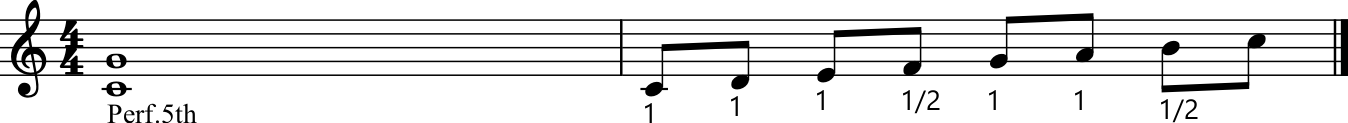

In [7]:
example1 = "INFO treble c 4/4 120 INFO (c4,g4)w[Perf.5th] c4e[1] d4e[1] e4e[1] f4e[1/2] g4e[1] a4e[1] b4e[1/2] c5e"

print("Example 1")

music(example1, True)
music(example1)

There are basically two kinds of intervals: *melodic* and *harmonic*. Melodic intervals are those which involve two successive tones and harmonic intervals consist of two tones which occur simultaneously.

Example 2


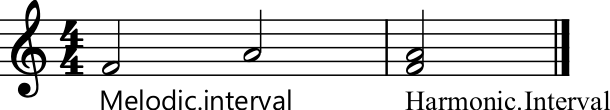

In [9]:
example2 = "INFO treble c 4/4 120 INFO f4h[Melodic.interval] a4h (f4,a4)h[Harmonic.Interval]"

print("Example 2")

music(example2, True)
music(example2)

Another way of conceiving intervals is to relate them to some portion of a major or minor scale. For example, a major 3rd is composed of the 1st and 3rd notes of a major scale. A good knowledge of major and minor scales is essential to many kinds of theoretical activity.

Example 3a


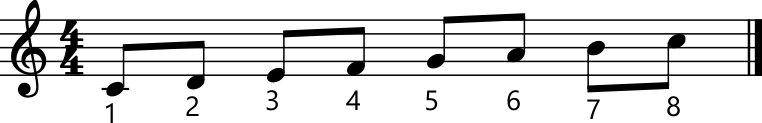

In [10]:
example3a = "INFO treble c 4/4 120 INFO c4e[1] d4e[2] e4e[3] f4e[4] g4e[5] a4e[6] b4e[7] c5e[8]"

print("Example 3a")

music(example3a, True)
music(example3a)

**In the above example, the `1` to `3` is a Major 3rd*

Example 3b


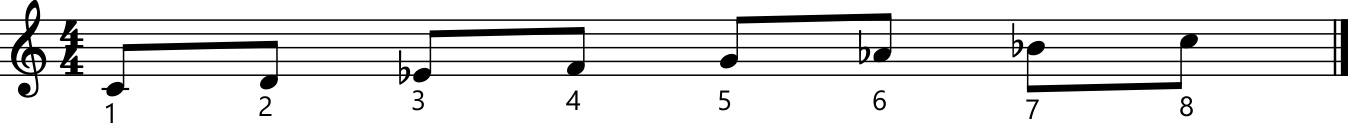

In [11]:
example3b = "INFO treble c 4/4 120 INFO c4e[1] d4e[2] e-4e[3] f4e[4] g4e[5] a-4e[6] b-4e[7] c5e[8]"

print("Example 3b")

music(example3b, True)
music(example3b)

**In the above example, the `1` to `6` is a Minor 6th*

The following chart displays the most common major, minor, and perfect intervals. They are described in three ways: 1. by the number of whole and/or half steps, 2. by combining two smaller intervals, and 3. by locating them in a major or minor scale.

| Interval | Number of steps | Interval combination | Location |
| :--- | :--- | :--- | :--- |
| minor 2nd | 1/2 step | (none smaller) | closest of all intervals |
| major 2nd | 1 whole step | 2 half steps | 1 & 2, major |
| minor 3rd | 1 1/2 steps | 3 half steps | 1 & 3, minor |
| major 3rd | 2 whole steps | 4 half steps | 1 & 3, major |
| perfect 4th | 2 1/2 steps | major 3rd and half step,<br>minor 3rd and whole step | 1 & 4, major or minor |
| perfect 5th | 3 1/2 steps | major 3rd and minor 3rd,<br>perfect 4th and whole step | 1 & 5, major or minor |
| minor 6th | 4 whole steps | minor 3rd and perfect 4th,<br>two major 3rds,<br>perfect 5th and whole step | 1 & 6, minor |
| major 6th | 4 1/2 steps | major 3rd and perfect 4th,<br>perfect 5th and whole step | 1 & 6, major |
| minor 7th | 5 whole steps | minor 3rd and perfect 5th,<br>two perfect 4ths | 1 & 7, minor |
| major 7th | 5 1/2 steps | perfect 5th and major 3rd | 1 & 7, major |
| octave | 6 whole steps | perfect 5th and perfect 4th | 1 & 8, major or minor |

A musician should be able to spell intervals correctly and enharmonically. That is, a 3rd should involve two letters a 3rd apart, a 5th should involve two letters a 5th apart, and so on. However, for various musical reasons, intervals are often "misspelled" enharmonically with letters that produce the correct sound but are not the correct distance apart. The following example shows both the correct and enharmonic spelling of several intervals.

In [ ]:
example4 = "INFO treble c 4/4 120 INFO (f4,b-4)h (f4,a#4)"

print("Example 4")

music(example4, True)
music(example4)